# **Use case: Optimization**

## We are going to implement QAOA for the MaxCut problem

we start by importing qiskit to simulate circuits and some other basic libraries

In [1]:
from qiskit import *
import numpy as np
import pylab as pl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import networkx as nx
from qiskit.visualization import *

networkx can be used to handle graphs

(array([0, 1]), array([0, 1]))

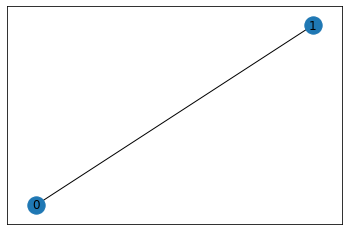

In [2]:
V = np.arange(0,2,1)
E =[(0,1,1.0)] 

G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

nx.draw_networkx(G)
np.array(list(G.nodes)), V

We define a function that creates our circuit

In [3]:
def createCircuit(x,G,depth):
    V = list(G.nodes)
    num_V = len(V)
    q = QuantumRegister(num_V)
    c = ClassicalRegister(num_V)
    circ = QuantumCircuit(q,c)
    #uniform superposition
    circ.h(range(num_V))
    circ.barrier()
    for d in range(depth):
        gamma=x[2*d]
        beta=x[2*d+1]
        #go through all edges and add Rzz gate
        for edge in G.edges():
            i=int(edge[0])
            j=int(edge[1])
            w = G[i][j]['weight']
            circ.cx(q[i],q[j])
            circ.rz(w*gamma,q[j])
            circ.cx(q[i],q[j])
        circ.barrier()
        #add the mixer
        circ.rx(2*beta,range(num_V))
        circ.barrier()
    circ.measure(q,c)
    return circ

draw example circuits

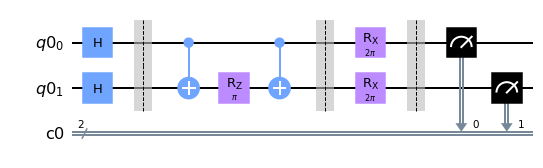

In [4]:
createCircuit(np.array((np.pi,np.pi)),G,1).draw(output='mpl')

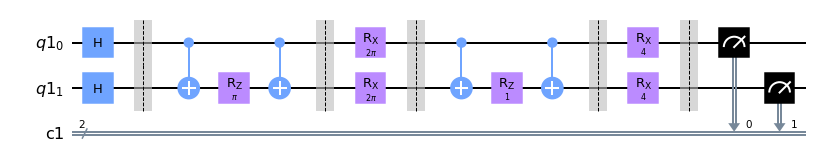

In [5]:
createCircuit(np.array((np.pi,np.pi,1,2)),G,2).draw(output='mpl')

in order to evaluate a solution we define a function that gives us the cost

In [6]:
def cost(x,G):
    C=0
    for edge in G.edges():
        i = int(edge[0])
        j = int(edge[1])
        w = G[i][j]['weight']
        C = C + w/2*(1-(2*x[i]-1)*(2*x[j]-1))
    return C

brute force function that lists all 2^n possibilities and finds the best solutions (use with caution)

In [7]:
def listcosts(G):
    costs={}
    maximum=0
    solutions=[]
    V = list(G.nodes)
    num_V = len(V)
    for i in range(2**num_V):
        binstring="{0:b}".format(i).zfill(num_V)
        y=[int(i) for i in binstring]
        costs[binstring]=cost(y,G)
        maximum = max(maximum,costs[binstring])
    for key in costs:
        if costs[key]==maximum:
            solutions.append(key)
    return costs, maximum, solutions

In [8]:
listcosts(G)

({'00': 0.0, '01': 1.0, '10': 1.0, '11': 0.0}, 1.0, ['01', '10'])

the result of a circuit contains a dictionary containing bitstrings together with how many times they have occured

we define a function that gives us (an approximation of) the expectationvalue based on this

In [9]:
def expectationValue(data,G):
    res=data.result().results
    E=[]
    V = list(G.nodes)
    num_V = G.number_of_nodes()
    for result in res:
        n_shots = result.shots
        counts = result.data.counts
        e = 0
        for hexkey in list(counts.keys()):
            count = counts[hexkey]
            binstring = "{0:b}".format(int(hexkey,0)).zfill(num_V)
            y=[int(i) for i in binstring]
            e += cost(y,G)*count/n_shots
        E.append(-e)
    return E

we will use an ideal simulator

In [10]:
ideal_sim = Aer.get_backend('qasm_simulator')

to get the energy/training/cost landscape for depth p=1, we sample the region $[0,\frac{\pi}{2}]^2$

In [11]:
circuits=[]
n=16
for gamma in np.linspace(0,np.pi,n):
    for beta in np.linspace(0,np.pi,n):
        circuits.append(createCircuit(np.array((gamma,beta)),G,1))

In [12]:
job_sim = execute(circuits, ideal_sim, shots=1024*2*2*2)

In [13]:
val=expectationValue(job_sim,G)
E=np.array(val).reshape(n,n)

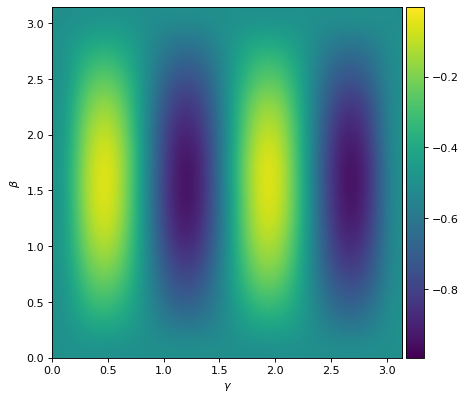

In [14]:
f = pl.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k');
_=pl.xlabel(r'$\gamma$')
_=pl.ylabel(r'$\beta$')
ax = pl.gca()
im = ax.imshow(E,interpolation='bicubic',origin='lower',extent=[0,np.pi,0,np.pi])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
_=pl.colorbar(im, cax=cax)

we import minimizers from scipy to do local minimization

In [15]:
from scipy import optimize as opt

the minimize funciton needs a function to evalution, which we create next

In [16]:
def getval(x, backend):
    circ=createCircuit(x,G,1)
    tcirc = transpile(circ, backend)
    j = execute(tcirc, backend, shots=1024*2*2*2)
    val=expectationValue(j,G)
    return val[0]

In [17]:
out=opt.minimize(getval, x0=(1, 1), method='Nelder-Mead',\
                 args=(ideal_sim),\
             options={'xatol': 1e-2, 'fatol': 1e-2, 'disp': True})

Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 18
         Function evaluations: 36


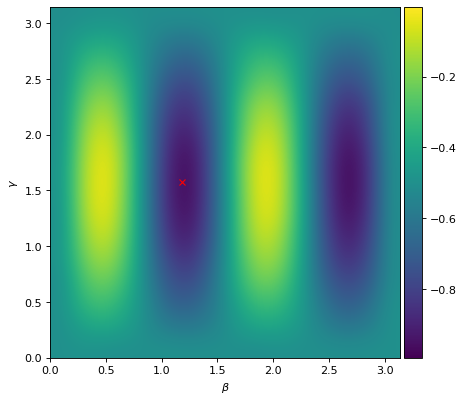

In [18]:
f = pl.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k');
_=pl.xlabel(r'$\beta$')
_=pl.ylabel(r'$\gamma$')
ax = pl.gca()
im = ax.imshow(E,interpolation='bicubic',origin='lower',extent=[0,np.pi,0,np.pi])
_=pl.plot(out.x[1],out.x[0],'xr')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
_=pl.colorbar(im, cax=cax)


let's plot the histogram

In [19]:
j = execute(createCircuit(out.x,G,1), ideal_sim, shots=1024*2*2*2)

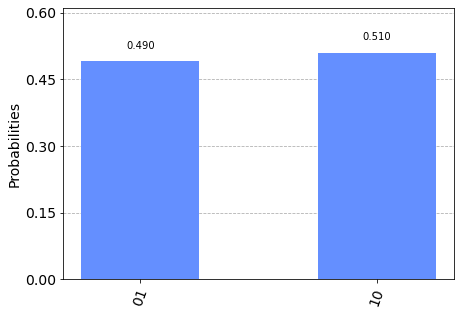

In [20]:
plot_histogram(j.result().get_counts())

next, let's see the effect of noise

we use a backend that emulates a real device "Vigo"

In [21]:
from qiskit.providers.aer import AerSimulator

In [22]:
from qiskit.test.mock import FakeVigo
device_backend = FakeVigo()
sim_vigo = AerSimulator.from_backend(device_backend)

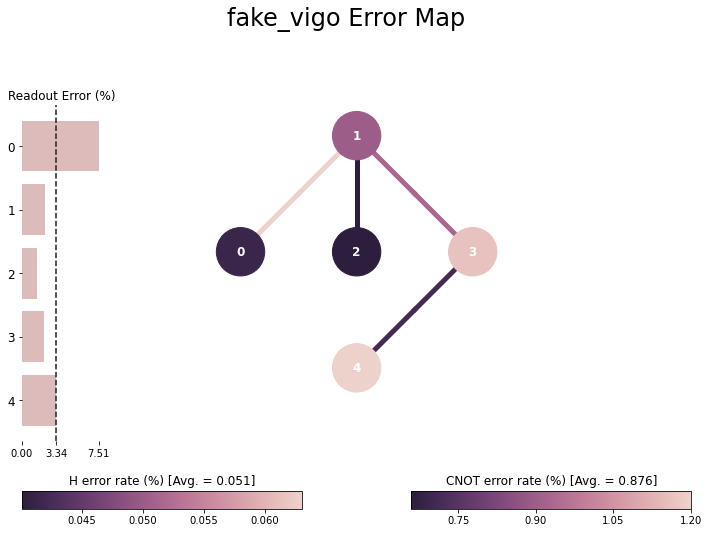

In [23]:
plot_error_map(FakeVigo())

again, we sample the energy/training/cost landscape for depth p=1

In [24]:
noisy_circuits=[]
n=16
for gamma in np.linspace(0,np.pi,n):
    for beta in np.linspace(0,np.pi,n):
        circ=createCircuit(np.array((gamma,beta)),G,1)
        #we need to transpile the circuit for the backend
        tcirc=transpile(circ,sim_vigo)
        noisy_circuits.append(tcirc)

In [25]:
job_sim_noise = execute(noisy_circuits, sim_vigo, shots=1024*2*2*2)

In [26]:
val_noise=expectationValue(job_sim_noise,G)
E_noise=np.array(val_noise).reshape(n,n)

we can now compare the landscape from the ideal and noisy simulation

(the circuit consist of only 2 qubits and 2 cnot gates)

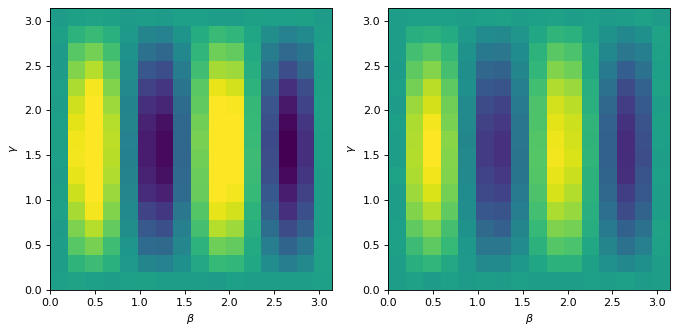

In [27]:
f, axarr = pl.subplots(1,2,figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
vmin=min(np.min(E),np.min(E_noise))
vmax=min(np.max(E),np.max(E_noise))
_=axarr[0].imshow(E,vmin=vmin,vmax=vmax,origin='lower',extent=[0,np.pi,0,np.pi])
_=axarr[1].imshow(E_noise,vmin=vmin,vmax=vmax,origin='lower',extent=[0,np.pi,0,np.pi])
for i in range(2):
    _=axarr[i].set_xlabel(r'$\beta$')
    _=axarr[i].set_ylabel(r'$\gamma$')

In [28]:
out_noise=opt.minimize(getval, x0=(1,1),\
                       args=(sim_vigo), method='Nelder-Mead',\
             options={'xatol': 1e-2, 'fatol': 1e-2, 'disp': True})

Optimization terminated successfully.
         Current function value: -0.894897
         Iterations: 20
         Function evaluations: 48


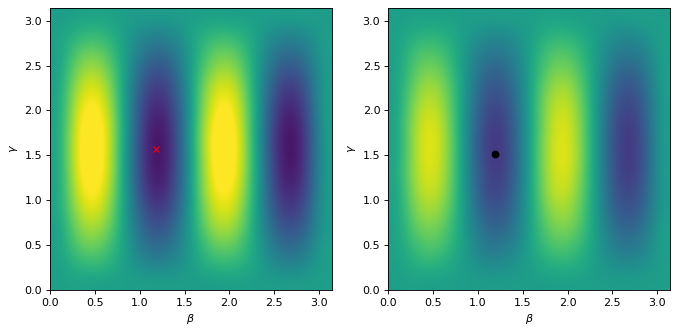

In [29]:
f, axarr = pl.subplots(1,2,figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
vmin=min(np.min(E),np.min(E_noise))
vmax=min(np.max(E),np.max(E_noise))
_=axarr[0].imshow(E,vmin=vmin,vmax=vmax,origin='lower',extent=[0,np.pi,0,np.pi],interpolation='bicubic')
_=axarr[1].imshow(E_noise,vmin=vmin,vmax=vmax,origin='lower',extent=[0,np.pi,0,np.pi],interpolation='bicubic')
_=axarr[0].plot(out.x[1],out.x[0],'xr')
_=axarr[1].plot(out_noise.x[1],out_noise.x[0],'ok')
for i in range(2):
    _=axarr[i].set_xlabel(r'$\beta$')
    _=axarr[i].set_ylabel(r'$\gamma$')

let's plot the histogram. How did the noise effect it?

In [30]:
circ=createCircuit(out_noise.x,G,1)
tcirc=transpile(circ,sim_vigo)
j = execute(tcirc, sim_vigo, shots=1024*2*2*2)

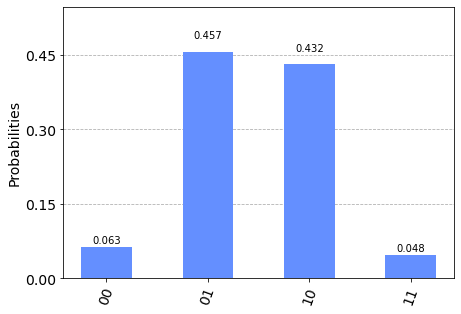

In [31]:
plot_histogram(j.result().get_counts())

finally, let's create a larger circuit

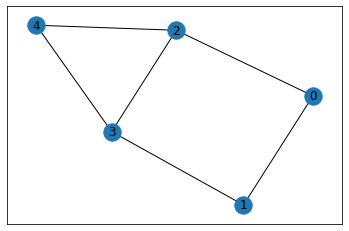

In [32]:
V = np.arange(0,5,1)
E =[(0,1,1.0),(0,2,1.0),(2,3,1.0),(3,1,1.0),(3,4,1.0),(4,2,1.0)]

G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

nx.draw_networkx(G)

what are the solutions?

In [33]:
l,m,maxcost=listcosts(G)
print(m,maxcost)

5.0 ['01100', '01101', '10010', '10011']


how does the circuit look?

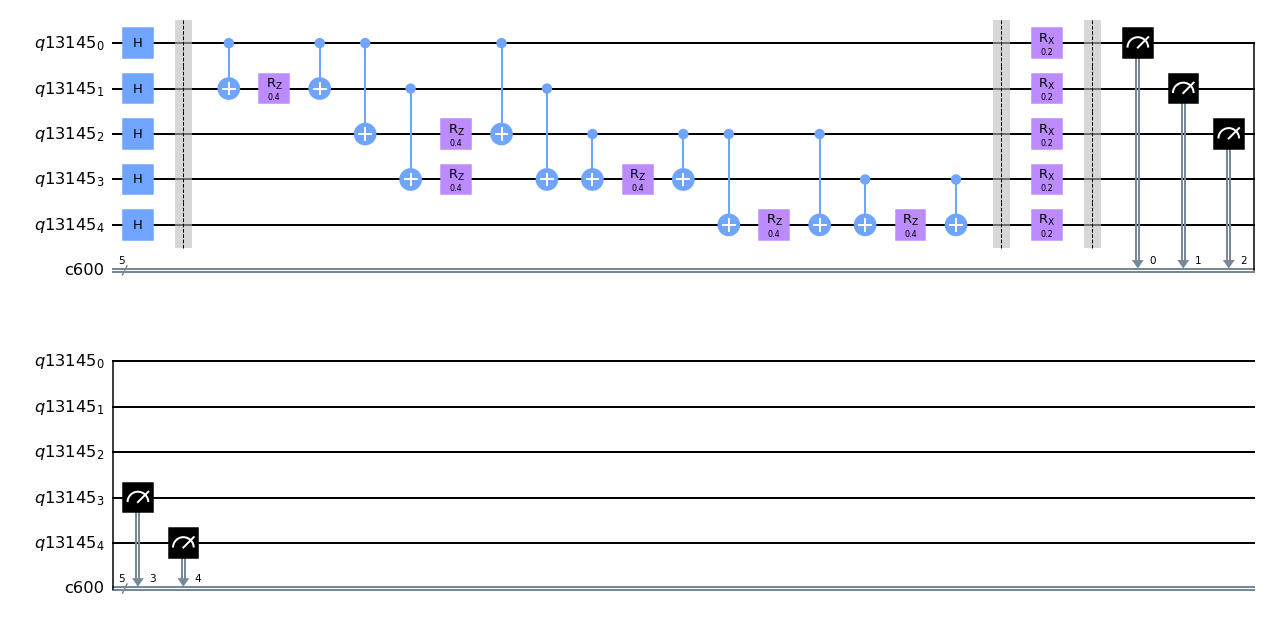

In [34]:
createCircuit(np.array((0.4,0.1)),G,1).draw(output='mpl')

how does the circuit look on a real device?

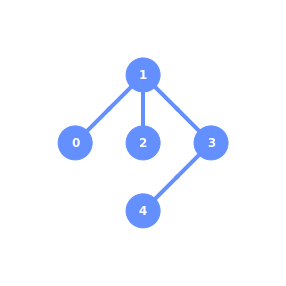

In [35]:
plot_gate_map(FakeVigo())

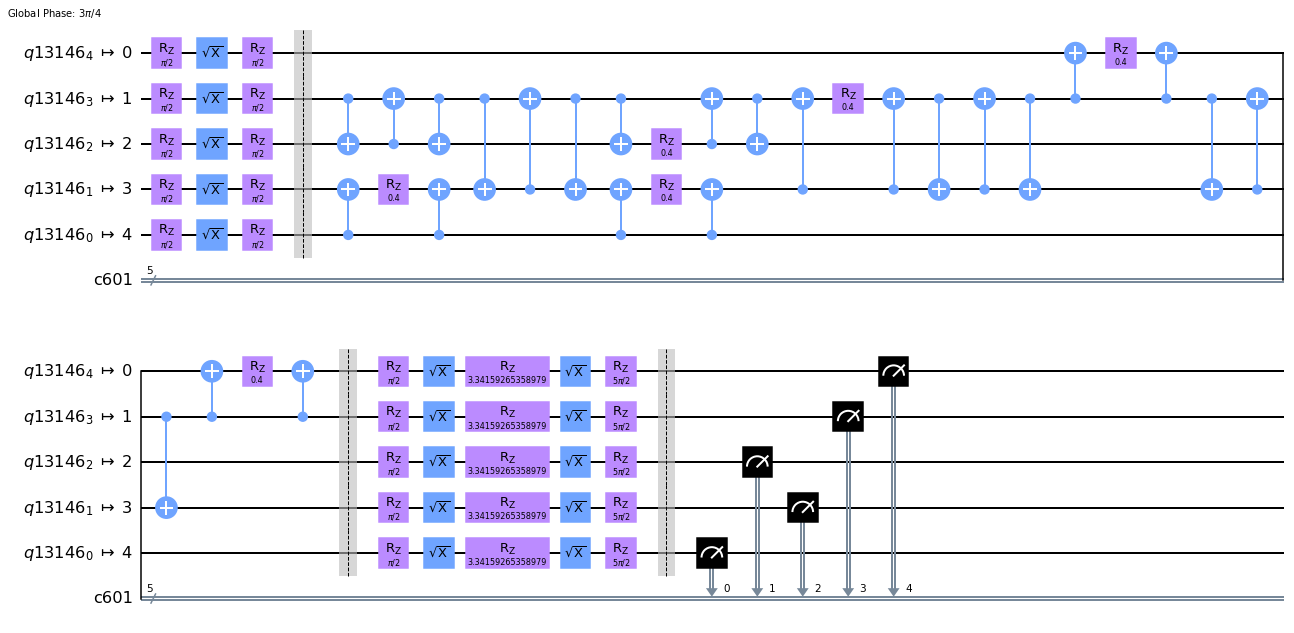

In [36]:
transpile(createCircuit(np.array((0.4,0.1)),G,1),backend=sim_vigo).draw(output='mpl')

create energy landscapes for ideal and noisy simulations

In [37]:
circuits=[]
n=16
for gamma in np.linspace(0,np.pi,n):
    for beta in np.linspace(0,np.pi,n):
        circ=createCircuit(np.array((gamma,beta)),G,1)
        circuits.append(circ)

job_sim = execute(circuits, ideal_sim, shots=1024*2*2*2)

val=expectationValue(job_sim,G)
E=np.array(val).reshape(n,n)

In [38]:
noisy_circuits=[]
n=16
for gamma in np.linspace(0,np.pi,n):
    for beta in np.linspace(0,np.pi,n):
        circ=createCircuit(np.array((gamma,beta)),G,1)
        #we need to transpile the circuit for the backend
        tcirc=transpile(circ,sim_vigo)
        noisy_circuits.append(tcirc)

job_sim_noisy = execute(noisy_circuits, sim_vigo, shots=1024*2*2*2)

val_noisy=expectationValue(job_sim_noisy,G)
E_noise=np.array(val_noisy).reshape(n,n)

a comparison of the energy landscapes

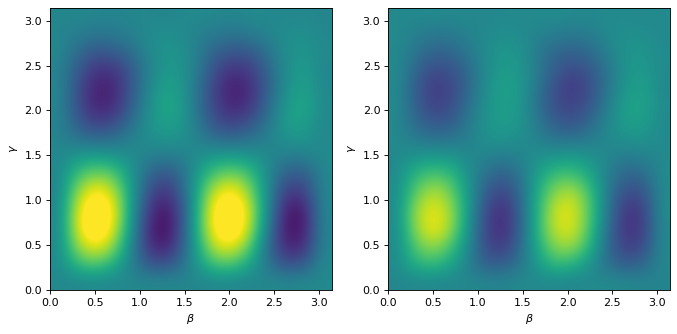

In [39]:
f, axarr = pl.subplots(1,2,figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
vmin=min(np.min(E),np.min(E_noise))
vmax=min(np.max(E),np.max(E_noise))
_=axarr[0].imshow(E,vmin=vmin,vmax=vmax,origin='lower',extent=[0,np.pi,0,np.pi],interpolation='bicubic')
_=axarr[1].imshow(E_noise,vmin=vmin,vmax=vmax,origin='lower',extent=[0,np.pi,0,np.pi],interpolation='bicubic')
# _=axarr[0].plot(out.x[1],out.x[0],'xr')
# _=axarr[1].plot(out_noise.x[1],out_noise.x[0],'ok')
for i in range(2):
    _=axarr[i].set_xlabel(r'$\beta$')
    _=axarr[i].set_ylabel(r'$\gamma$')

histograms of the best solution at depth p=1

Optimization terminated successfully.
         Current function value: -3.890503
         Iterations: 14
         Function evaluations: 28


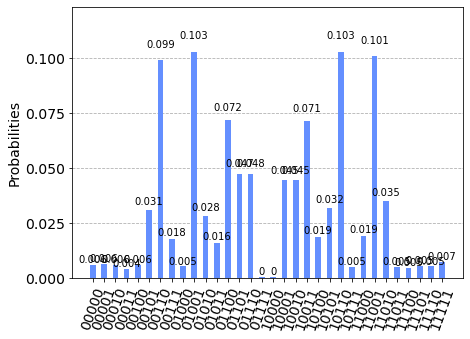

In [40]:
out=opt.minimize(getval, x0=(1,1),\
                       args=(ideal_sim), method='Nelder-Mead',\
             options={'xatol': 1e-2, 'fatol': 1e-2, 'disp': True})
circ=createCircuit(out.x,G,1)
j = execute(circ, ideal_sim, shots=1024*2*2*2)
plot_histogram(j.result().get_counts())

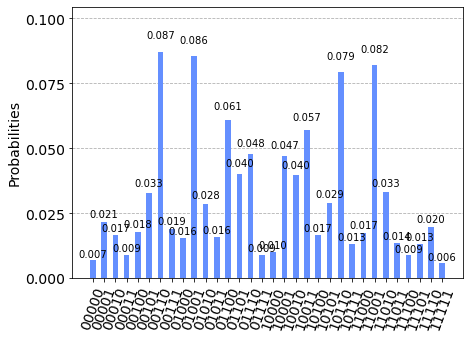

In [41]:
out_noise=opt.minimize(getval, x0=(1,1),\
                       args=(sim_vigo), method='Nelder-Mead',\
             options={'xatol': 1e-2, 'fatol': 1e-2, 'disp': True})
circ=createCircuit(out_noise.x,G,1)
tcirc=transpile(circ,sim_vigo)
j = execute(tcirc, sim_vigo, shots=1024*2*2*2)
plot_histogram(j.result().get_counts())

Where to go next? Try increasing the depth...